# Normalizing and encoding the data

In [ ]:
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [ ]:
# We will use a set random seed when calling df.sample for reproducibility
PD_RANDOM_STATE = 1

In [ ]:
# Give the notebook access to the rest of your google drive files.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra/'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing .py modules stored in FOLDERNAME or a subdirectory:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


# Importing Data

Only use the training set.

In [ ]:
balanced_train_file = 'balanced_filtered_data_train.feather'
large_train_file = 'large_filtered_data_train.feather'
SUBDIR = 'data/data_splits/'
balanced_path = FOLDERNAME + SUBDIR + balanced_train_file
large_file = FOLDERNAME + SUBDIR + large_train_file

!cp '{large_file}' .
!cp '{balanced_path}' .
!ls

balanced_filtered_data_test.feather	   drive
balanced_filtered_data_train.feather	   large_filtered_data_train.feather
balanced_filtered_data_validation.feather  sample_data


In [ ]:
balanced_train_df = pd.read_feather(balanced_train_file, columns=['title', 'abstract', 'source'])
balanced_train_df.head()

,title,abstract,source
0,REITS: Reflective Surface for Intelligent Tran...,Autonomous vehicles are predicted to dominat...,arxiv
1,Mirror Images and Division by Zero Calculus,Very classical results on the mirror images of...,vixra
2,Electromagnetic Waves in an Expanding 5D Universe,Electromagnetism is analyzed in a 5D expanding...,vixra
3,Atomic-Scale Erector,To design buildings that can withstand the lar...,vixra
4,Temperature dependence of microwave and THz di...,"The microwave, near-millimetre and infrared ...",arxiv


In [ ]:
large_train_df = pd.read_feather(large_train_file, columns=['title', 'abstract', 'source'])
large_train_df.head()

,title,abstract,source
0,Graphene Helicoid: The Distinct Properties Pro...,The extremely high thermal conductivity of g...,arxiv
1,Harmonic decomposition of three-particle azimu...,We present measurements of three-particle co...,arxiv
2,Ergodicity of some open systems with particle-...,We consider steady states for a class of mec...,arxiv
3,Unconventional research in USSR and Russia: sh...,This work briefly surveys unconventional res...,arxiv
4,Complexity Measures from Interaction Structures,We evaluate new complexity measures on the s...,arxiv


# Importance of Normalizing

Let's build up the sets of characters for arxiv and vixra papers for each dataset. Just look at the balanced dataset for now.

In [ ]:
balanced_train_df_dic = {key: balanced_train_df[balanced_train_df['source'] == key] for key in {'arxiv', 'vixra'}}

We perform some mild normalization at this stage by using `lower` on the text. In particular, we don't `strip`.

In [ ]:
def mild_normalizer(s):
    return s.lower()

In [ ]:
balanced_train_char_mild_norm_dic = {}
for key, df in balanced_train_df_dic.items():
    for text_col in ('title', 'abstract'):
        temp_char_set = set(' ') # Start with a space in the set.
        for text in df[text_col]:
            for char in text:
                new_char = mild_normalizer(char)
                temp_char_set.add(new_char)
        balanced_train_char_mild_norm_dic[f'{key}_{text_col}_chars'] = temp_char_set   

Check out the number of unique characters in each slice of the dataset:

In [ ]:
print(*((key, len(val)) for key, val in balanced_train_char_mild_norm_dic.items()), sep='\n')

('arxiv_title_chars', 71)
('arxiv_abstract_chars', 71)
('vixra_title_chars', 172)
('vixra_abstract_chars', 393)


In [ ]:
balanced_train_char_mild_norm_differences_dic = {}
for key1, key2 in (('vixra_title_chars', 'arxiv_title_chars'),
             ('arxiv_title_chars', 'vixra_title_chars'),
             ('vixra_abstract_chars', 'arxiv_abstract_chars'),
             ('arxiv_abstract_chars', 'vixra_abstract_chars')
             ):
    balanced_train_char_mild_norm_differences_dic[f"{key1.replace('_chars', '')}_only"] = [char for char in balanced_train_char_mild_norm_dic[key1] - balanced_train_char_mild_norm_dic[key2]]

In [ ]:
for key, item in balanced_train_char_mild_norm_differences_dic.items():
    print(key, item)

vixra_title_only ['δ', '≤', 'μ', 'ă', 'ś', '─', '—', 'ä', 'é', '¡', '\u3000', '¶', 'т', 'à', '‐', 'ê', '》', '¯', 'ⅲ', '»', 'γ', '：', 'ⅰ', '．', 'ș', 'ô', 'σ', '\xa0', 'í', 'ψ', 'â', '´', 'τ', 'ù', '�', 'ζ', '“', 'è', 'ξ', 'π', 'ö', 'ó', '®', 'ő', '）', '‒', '–', 'β', 'ş', '《', '―', '¸', 'ı', '∫', '‑', 'ℇ', 'ν', 'о', '‘', '≥', 'ñ', 'ω', 'µ', '²', '«', '∙', '\xad', '×', '\u200e', 'ú', 'ﬀ', '…', 'ã', 'ï', '̶', '′', '≡', '∗', '→', 'ğ', '√', 'ﬂ', '’', '\u200b', 'ü', '−', 'ϕ', 'á', 'φ', 'ӧ', '÷', '¨', 'ç', 'λ', 'ε', '±', 'α', '∈', '§', 'ﬁ', '”', '\uf061', 'æ']
arxiv_title_only ['\x7f', '\n']
vixra_abstract_only ['i̇', '\uf06d', 'ρ', 'μ', '̈', '℃', '⊝', 'е', '≢', 'ä', '\uf065', 'ŭ', '⟨', 'º', '\u202f', '\uf0bb', '∩', 'ϑ', '•', '」', '\x0b', 'ł', 'а', 'ę', '∼', '₂', 'ê', '‐', '》', '⋯', '\uf0e0', '¯', 'ʘ', '\u202c', '¢', '\uf02b', '̂', '⌈', '\uf0be', 'ḡ', '≠', '㎛', '\u2061', '①', 'ș', '┬', '·', '；', 'σ', '\xa0', '\uf03e', '\uf06a', 'ж', '™', 'â', 'ć', 'ଷ', 'ʹ', '⊆', '〖', '\uf044', 'و', 'κ', 'ђ', '

List all instances where a character appears only in arxiv or vixra and does so more than 1 percent of the time.

In [ ]:
for key, char_list in balanced_train_char_mild_norm_differences_dic.items():
    for char in char_list:
        key_split = key.split('_')
        percent = 100 * balanced_train_df_dic[key_split[0]][key_split[1]].apply(lambda s: char in mild_normalizer(s)).mean()
        if percent > 1:
            print(f'{(char, ord(char))} appears in {percent:.3f} percent of {key_split[0]} {key_split[1]}s')

('’', 8217) appears in 1.827 percent of vixra titles
('\n', 10) appears in 41.495 percent of arxiv titles
('ö', 246) appears in 1.007 percent of vixra abstracts
('–', 8211) appears in 3.437 percent of vixra abstracts
('‘', 8216) appears in 1.924 percent of vixra abstracts
('’', 8217) appears in 11.963 percent of vixra abstracts
('—', 8212) appears in 2.043 percent of vixra abstracts
('“', 8220) appears in 5.059 percent of vixra abstracts
('\r', 13) appears in 35.513 percent of vixra abstracts
('”', 8221) appears in 5.105 percent of vixra abstracts


Let's look at where the `\n` and `\r` chars appear in arxiv titles and vixra abstracts, respectively.

In [ ]:
for title in balanced_train_df_dic['arxiv']['title'][balanced_train_df_dic['arxiv']['title'].apply(lambda x: '\n' in x)].sample(5, random_state=PD_RANDOM_STATE):
    print(title.__repr__(), '\n') # For printing raw text.
print(50 * '-')
for text in balanced_train_df_dic['vixra']['abstract'][balanced_train_df_dic['vixra']['abstract'].apply(lambda x: '\r' in x)].sample(5, random_state=PD_RANDOM_STATE):
    print(text.__repr__(), '\n') # For printing raw text.

'Hedging Strategies for Load-Serving Entities in Wholesale Electricity\n  Markets' 

'A new ordering principle for the classical statistical analysis of\n  Poisson processes with background' 

'The Quantum Group Structure of 2D Gravity and Minimal Models II: The\n  Genus-Zero Chiral Bootstrap' 

'Conservation relation of nonclassicality and entanglement for Gaussian\n  states in a beam-splitter' 

'SmoothOut: Smoothing Out Sharp Minima to Improve Generalization in Deep\n  Learning' 

--------------------------------------------------
'With a new proof approach, \r\nwe show that the  normal distribution with mean zero and variance $1/3$  is the  distribution of   the integrals $\\int_{[0,1]}W_{t}\\df t$ of the sample paths of Wiener process $W$ in $C([0,1], \\R)$.' 

'StarGAN, which has impressive performance in multi-domain image-to-image translation. Reconstruction loss of StarGAN requires reconstructed data from generated data, which means to get reconstruction loss, need to use the 

While some of this information might have signal, a lot of it is also not able to be seen by humans and would make the comparison unfair, e.g. the difference between underscores or appearance of carriage returns `\r`

The bigger problem, it turns out, is the lack of `.strip()`-ing white space, particularly in the arxiv abstracts: every arxiv abstract ends in \n, while none of the vixra ones do. They also seem to start with a space

In [ ]:
for key, df in balanced_train_df_dic.items():
    for field in ('title', 'abstract'):
        print(f"Percent of \\n's appearing at end of {key} {field}s:",df[field].apply(lambda s: s[-1] == '\n').mean())
for key, df in balanced_train_df_dic.items():
    for field in ('title', 'abstract'):
        print(f'Percent of blank spaces appearing at start of {key} {field}s:',df[field].apply(lambda s: s[0] == ' ').mean())
print(50 * '-')
for text in balanced_train_df_dic['arxiv']['abstract'].sample(5, random_state=PD_RANDOM_STATE):
    print(text.__repr__(), '\n') # For printing raw text.

Percent of \n's appearing at end of arxiv titles: 0.0
Percent of \n's appearing at end of arxiv abstracts: 1.0
Percent of \n's appearing at end of vixra titles: 0.0
Percent of \n's appearing at end of vixra abstracts: 0.0
Percent of blank spaces appearing at start of arxiv titles: 0.0
Percent of blank spaces appearing at start of arxiv abstracts: 1.0
Percent of blank spaces appearing at start of vixra titles: 0.0
Percent of blank spaces appearing at start of vixra abstracts: 0.0
--------------------------------------------------
'  The efficiency of path sampling simulations can be improved considerably\nusing the approach of path swapping. For this purpose, we have devised a new\nalgorithmic procedure based on the transition interface sampling technique. In\nthe same spirit of parallel tempering, paths between different ensembles are\nswapped, but the role of temperature is here played by the interface position.\nWe have tested the method on the denaturation transition of DNA using th

Look at the other fields to check for similar issues. Nothing obvious.

In [ ]:
for text in balanced_train_df_dic['arxiv']['title'].sample(5, random_state=PD_RANDOM_STATE):
    print(text.__repr__(), '\n') # For printing raw text.
print(50 * '-')
for text in balanced_train_df_dic['vixra']['title'].sample(5, random_state=PD_RANDOM_STATE):
    print(text.__repr__(), '\n') # For printing raw text.
print(50 * '-')
for text in balanced_train_df_dic['vixra']['abstract'].sample(5, random_state=PD_RANDOM_STATE):
    print(text.__repr__(), '\n') # For printing raw text.

'Reaction rate calculation by parallel path swapping' 

'Sinkhorn Divergences for Unbalanced Optimal Transport' 

'High-Resolution X-ray Imaging of the Colliding Wind Shock in WR147' 

'Probing the Dynamics of Superradiant Quantum Phase Transition in a\n  Single Trapped-Ion' 

'Saito duality and the classical theory of arithmetic functions' 

--------------------------------------------------
'To Understand the Four Cosmological Interactions' 

'Two Large Errors: Newton First Law and Inertial Reference' 

'Physical Interactions as Geometric Processes' 

'Finding The Next Term Of Any Sequence Using Total Similarity & Dissimilarity {Version 5}. ISSN 1751-3030' 

'Major Principles of Physics: Poincaré Invariance, Analyticity, Unitarity and Complex Minkowski Space' 

--------------------------------------------------
'Considering the Hubble volume, cosmic critical density, Hubble mass and Avogadro number - in this paper an attempt is made to fit and understand the mystery of cosmic, atomic

This lets any ML architecture easily distinguish arxiv abstracts, if not handled.

To this end, let us apply a much stronger normalization where all text is converted to ASCII, spaces around non-alphanumeric chars are inserted, and all control chars are mapped to a blank space. We import `text_normalizer` from our custom package as the strong normalizer.

In [ ]:
%%capture text_normalizer_import --no-stderr
!pip install unidecode wandb pytorch-lightning
from arxiv_vixra_models import text_normalizer
from unidecode import unidecode

My `text_normalizer` is pretty brutal.  Examples of the replacements:

In [ ]:
with pd.option_context('display.max_rows', None):
    display(pd.DataFrame({'original': [ch for ch in balanced_train_char_mild_norm_differences_dic['vixra_title_only']],
                          'normalized': [text_normalizer(ch) for ch in balanced_train_char_mild_norm_differences_dic['vixra_title_only']]})
    )

,original,normalized
0,δ,d
1,≤,< =
2,μ,m
3,ă,a
4,ś,s
5,─,-
6,—,- -
7,ä,a
8,é,e
9,¡,!


In [ ]:
balanced_train_char_strong_norm_dic = {}
for key, df in balanced_train_df_dic.items():
    for text_col in ('title', 'abstract'):
        temp_char_set = set(' ') # Start with a space in the set.
        for text in df[text_col]:
            for char in text:
                new_char = text_normalizer(char)
                # Sometimes text_normalizer maps one non-ASCII char to multiple ASCII chars.
                for split_char in new_char:
                    temp_char_set.add(split_char)
        balanced_train_char_strong_norm_dic[f'{key}_{text_col}_chars'] = temp_char_set   

Check out the number of unique characters in each slice of the dataset:

In [ ]:
print(*((key, len(val)) for key, val in balanced_train_char_strong_norm_dic.items()), sep='\n')

('arxiv_title_chars', 69)
('arxiv_abstract_chars', 69)
('vixra_title_chars', 69)
('vixra_abstract_chars', 69)


In [ ]:
balanced_train_char_strong_norm_differences_dic = {}
for key1, key2 in (('vixra_title_chars', 'arxiv_title_chars'),
             ('arxiv_title_chars', 'vixra_title_chars'),
             ('vixra_abstract_chars', 'arxiv_abstract_chars'),
             ('arxiv_abstract_chars', 'vixra_abstract_chars')
             ):
    balanced_train_char_strong_norm_differences_dic[f"{key1.replace('_chars', '')}_only"] = [char for char in balanced_train_char_strong_norm_dic[key1] - balanced_train_char_strong_norm_dic[key2]]

In [ ]:
for key, item in balanced_train_char_strong_norm_differences_dic.items():
    print(key, item)

vixra_title_only []
arxiv_title_only []
vixra_abstract_only []
arxiv_abstract_only []


Percentages:

In [ ]:
for key, char_list in balanced_train_char_strong_norm_differences_dic.items():
    for char in char_list:
        key_split = key.split('_')
        percent = 100 * balanced_train_df_dic[key_split[0]][key_split[1]].apply(lambda s: char in text_normalizer(s)).mean()
        print(f'{(char, ord(char))} appears in {percent:.3f} percent of {key_split[0]} {key_split[1]}s')

This corresponds to just O(1) titles in the set

The char set we are using above is just all lower, non-control ASCII chars:

In [ ]:
import unicodedata
ascii_all_lower = set(chr(i).lower() for i in range(128))
ascii_control = set(ch for ch in ascii_all_lower if unicodedata.category(ch)[0]=='C')
ascii_all_lower_alpha_num = {ch for ch in ascii_all_lower if ch.isalnum()}
ascii_punctuation = ascii_all_lower - ascii_control - ascii_all_lower_alpha_num
normalized_char_set = ascii_all_lower_alpha_num | ascii_punctuation
print(normalized_char_set)
print(f'{len(normalized_char_set)} total characters.')

{'w', 'm', ',', '^', 'v', '+', '$', '`', 'y', '0', '4', 't', 'n', 'k', 'f', '&', '[', 'g', 'l', ']', '<', '=', '5', 'h', 'e', '~', 'u', 'i', '"', '7', '-', '#', 'o', ':', ' ', '}', '\\', 'r', 'q', '!', '@', "'", '*', '9', '{', '8', '(', '6', ')', 'c', ';', '>', 'p', 'b', '%', '?', 'j', '1', '2', '3', '_', 'a', 'z', '|', '/', 's', 'd', '.', 'x'}
69 total characters.


Export as a feather file.

In [ ]:
normalized_char_set = set()
for char_set in balanced_train_char_strong_norm_dic.values():
    normalized_char_set |= char_set
normalized_char_list = sorted(list(normalized_char_set))
# Sorting should place ' ' at index 0. Padding will be performed based on this assumption.
assert normalized_char_list[0] == ' '
normalized_char_dic = {char: idx for idx, char in enumerate(normalized_char_list)}
normalized_char_df = pd.DataFrame(list(normalized_char_dic.items()), columns=['char', 'idx'])
normalized_char_df.to_feather(FOLDERNAME + 'data/data_splits/normalized_char_set.feather')

# Normalizing the Text

Go through and strongly normalize the text everywhere, via `text_normalizer`.

Examine the output of the normalizer.

In [ ]:
text_normalizer_test_samples = balanced_train_df.head(10).abstract
for text in text_normalizer_test_samples:
    print(text + '\n', text_normalizer(text), 20 * '-', sep='\n')

  Autonomous vehicles are predicted to dominate the transportation industry in
the foreseeable future. Safety is one of the major challenges to the early
deployment of self-driving systems. To ensure safety, self-driving vehicles
must sense and detect humans, other vehicles, and road infrastructure
accurately, robustly, and timely. However, existing sensing techniques used by
self-driving vehicles may not be absolutely reliable. In this paper, we design
REITS, a system to improve the reliability of RF-based sensing modules for
autonomous vehicles. We conduct theoretical analysis on possible failures of
existing RF-based sensing systems. Based on the analysis, REITS adopts a
multi-antenna design, which enables constructive blind beamforming to return an
enhanced radar signal in the incident direction. REITS can also let the
existing radar system sense identification information by switching between
constructive beamforming state and destructive beamforming state. Preliminary
results sho

Normalize and export all data sets

In [ ]:
all_file_names = ('balanced_filtered_data_train.feather',
                  'balanced_filtered_data_validation.feather', 
                  'balanced_filtered_data_test.feather',
                  'large_filtered_data_train.feather'
                  )
df_list = []
for f in all_file_names:
    path = FOLDERNAME + SUBDIR + f
    !cp '{path}' .
    df_list.append(pd.read_feather(f, columns=['title', 'abstract', 'source']))
    temp_df = df_list[-1]
    temp_df['title'] = temp_df['title'].apply(text_normalizer)
    temp_df['abstract'] = temp_df['abstract'].apply(text_normalizer)
    idx = f.find('_data')
    out_name = f[:idx] + '_normalized' + f[idx:]
    print(f'saved {out_name}')
    temp_df.to_feather(FOLDERNAME + SUBDIR + out_name)

saved balanced_filtered_normalized_data_train.feather
saved balanced_filtered_normalized_data_validation.feather
saved balanced_filtered_normalized_data_test.feather
saved large_filtered_normalized_data_train.feather


We will work with the below training sets for the remainder of the notebook.

In [ ]:
balanced_train_normalized_df = df_list[all_file_names.index('balanced_filtered_data_train.feather')]
balanced_validation_normalized_df = df_list[all_file_names.index('balanced_filtered_data_validation.feather')]
large_train_normalized_df = df_list[all_file_names.index('large_filtered_data_train.feather')]

In [ ]:
len(balanced_train_normalized_df)

35142

The normalization process (the insertion of spaces around punctuation, in particular) increases the char length and word count of the various fields that we have previously cut on.  Check that the increase is not unacceptably drastic.

In [ ]:
print(balanced_train_normalized_df['title'].apply(lambda x: len(x) > 128).mean(),
      balanced_train_normalized_df['abstract'].apply(lambda x: len(x) > 2048).mean(),
      balanced_train_normalized_df['title'].apply(lambda x: len(x.split()) > 16).mean(),
      balanced_train_normalized_df['abstract'].apply(lambda x: len(x.split()) > 256).mean(),
      sep='\n')

0.00862216151613454
0.00011382391440441637
0.08459962438108247
0.08607933526833988


The overflow for char len is less than 1%, but for word counts it's ~10%, which is not great.  Increasing the threshold by 50% is brings the cut down below 1%, so we will increase the `seq_len` threshold for embedding models by a similar factor during training, as to not unneccessarily cut out additional data.

In [ ]:
print(balanced_train_normalized_df['title'].apply(lambda x: len(x.split()) > 1.5 * 16).mean(),
      balanced_train_normalized_df['abstract'].apply(lambda x: len(x.split()) > 1.5 * 256).mean(),
      sep='\n')

0.008479881623129019
0.003642365260941324


We also create versions of the training data which have their source column randomized, which will be used to test whether there is any accidental cheating in the network.

In [ ]:
balanced_train_normalized_randomized_source_df = balanced_train_normalized_df.copy()
# Need to reset the indices after shuffling, otherwise overwriting silently fails.
balanced_train_normalized_randomized_source_df_shuffle = balanced_train_normalized_randomized_source_df['source'].sample(frac=1, random_state=PD_RANDOM_STATE)
balanced_train_normalized_randomized_source_df_shuffle.index = balanced_train_normalized_randomized_source_df.index
balanced_train_normalized_randomized_source_df['source'] = balanced_train_normalized_randomized_source_df_shuffle
balanced_train_normalized_randomized_source_df.to_feather(FOLDERNAME + SUBDIR + 'balanced_filtered_normalized_data_randomized_source_train.feather')

In [ ]:
balanced_validation_normalized_randomized_source_df = balanced_validation_normalized_df.copy()
# Need to reset the indices after shuffling, otherwise overwriting silently fails.
balanced_validation_normalized_randomized_source_df_shuffle = balanced_validation_normalized_randomized_source_df['source'].sample(frac=1, random_state=PD_RANDOM_STATE)
balanced_validation_normalized_randomized_source_df_shuffle.index = balanced_validation_normalized_randomized_source_df.index
balanced_validation_normalized_randomized_source_df['source'] = balanced_validation_normalized_randomized_source_df_shuffle
balanced_validation_normalized_randomized_source_df.to_feather(FOLDERNAME + SUBDIR + 'balanced_filtered_normalized_data_randomized_source_validation.feather')

In [ ]:
large_train_normalized_randomized_source_df = large_train_normalized_df.copy()
# Need to reset the indices after shuffling, otherwise overwriting silently fails.
large_train_normalized_randomized_source_df_shuffle = large_train_normalized_randomized_source_df['source'].sample(frac=1, random_state=PD_RANDOM_STATE)
large_train_normalized_randomized_source_df_shuffle.index = large_train_normalized_randomized_source_df.index
large_train_normalized_randomized_source_df['source'] = large_train_normalized_randomized_source_df_shuffle
large_train_normalized_randomized_source_df.to_feather(FOLDERNAME + SUBDIR + 'large_filtered_normalized_data_randomized_source_train.feather')

Sanity check that the indices are really shuffled. The numbers in the tuple should be close to each other, since 'vixra' never appears in arxiv abstracts.


In [ ]:
for df in (balanced_train_normalized_randomized_source_df, 
           large_train_normalized_randomized_source_df):
    # P(source == 'arxiv' | 'vixra' in 'abstract')
    vixra_in_arxiv_abstract_frac = (df[df['abstract'].apply(lambda x: 'vixra' in x)]['source'] == 'arxiv').mean()
    # vixra-to-arxiv ratio
    arxiv_to_vixra_ratio = (df['source'] == 'arxiv').mean()
    print(vixra_in_arxiv_abstract_frac, arxiv_to_vixra_ratio)

0.49640287769784175 0.5
0.9859154929577465 0.9894184550129309


## Vocabularies

Get the unique words in titles and abstracts from the various datasets along with their counts.  We create dataframes with `word` and `count` columns, since we may want to filter on frequency.

Titles:

In [ ]:
balanced_title_normalized_word_counter = {}
for _, title in balanced_train_normalized_df['title'].iteritems():
    for word in title.split():
        balanced_title_normalized_word_counter[word] = balanced_title_normalized_word_counter.get(word, 0) + 1
# Turn into a dataframe with word, count, and idx (1-indexed), sorted by count
balanced_title_normalized_words, balanced_title_normalized_counts = zip(*sorted(balanced_title_normalized_word_counter.items(), key = lambda x: x[1], reverse=True))
balanced_title_normalized_vocab = {**{'word': balanced_title_normalized_words},
                        **{'count': balanced_title_normalized_counts}}
balanced_title_normalized_vocab_df = pd.DataFrame(balanced_title_normalized_vocab)
balanced_title_normalized_vocab_df.head()

,word,count
0,of,16881
1,-,15158
2,the,13569
3,and,9737
4,in,7861


In [ ]:
large_title_normalized_word_counter = {}
for _, title in large_train_normalized_df['title'].iteritems():
    for word in title.split():
        large_title_normalized_word_counter[word] = large_title_normalized_word_counter.get(word, 0) + 1
# Turn into a dataframe with word, count, and idx (1-indexed), sorted by count
large_title_normalized_words, large_title_normalized_counts = zip(*sorted(large_title_normalized_word_counter.items(), key = lambda x: x[1], reverse=True))
large_title_normalized_vocab = {**{'word': large_title_normalized_words}, **{'count': large_title_normalized_counts}}
large_title_normalized_vocab_df = pd.DataFrame(large_title_normalized_vocab)
large_title_normalized_vocab_df.head()

,word,count
0,-,997188
1,of,825541
2,the,578643
3,in,500106
4,and,481664


Abstracts

In [ ]:
balanced_abstract_normalized_word_counter = {}
for _, abstract in balanced_train_normalized_df['abstract'].iteritems():
    for word in abstract.split():
        balanced_abstract_normalized_word_counter[word] = balanced_abstract_normalized_word_counter.get(word, 0) + 1
# Turn into a dataframe with word, count, and idx (1-indexed), sorted by count
balanced_abstract_normalized_words, balanced_abstract_normalized_counts = zip(*sorted(balanced_abstract_normalized_word_counter.items(), key = lambda x: x[1], reverse=True))
balanced_abstract_normalized_vocab = {**{'word': balanced_abstract_normalized_words},
                        **{'count': balanced_abstract_normalized_counts}}
balanced_abstract_normalized_vocab_df = pd.DataFrame(balanced_abstract_normalized_vocab)
balanced_abstract_normalized_vocab_df.head()

,word,count
0,the,284504
1,.,181363
2,of,179986
3,",",155798
4,-,103144


In [ ]:
large_abstract_normalized_word_counter = {}
for _, abstract in large_train_normalized_df['abstract'].iteritems():
    for word in abstract.split():
        large_abstract_normalized_word_counter[word] = large_abstract_normalized_word_counter.get(word, 0) + 1
# Turn into a dataframe with word, count, and idx (1-indexed), sorted by count
large_abstract_normalized_words, large_abstract_normalized_counts = zip(*sorted(large_abstract_normalized_word_counter.items(), key = lambda x: x[1], reverse=True))
large_abstract_normalized_vocab = {**{'word': large_abstract_normalized_words},
                        **{'count': large_abstract_normalized_counts}}
large_abstract_normalized_vocab_df = pd.DataFrame(large_abstract_normalized_vocab)
large_abstract_normalized_vocab_df.head()

,word,count
0,the,15959835
1,.,10036994
2,of,9709506
3,",",8385499
4,-,6825851


### Look into the statistics of the word sets

Titles

In [ ]:
balanced_title_normalized_vocab_df['count'].describe()

count   23946.000000
mean       14.654640
std       209.052981
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max     16881.000000
Name: count, dtype: float64

Filtering on words which appear more than twice already hugely cleaves the data.

In [ ]:
(balanced_title_normalized_vocab_df['count'] > 2).mean()

0.35496533867869373

In [ ]:
balanced_title_normalized_vocab_df[balanced_title_normalized_vocab_df['count'] < 2]

,word,count
11748,reits,1
11749,erector,1
11750,srn,1
11751,1tino3n,1
11752,isic,1
...,...,...
23941,condensing,1
23942,anyone,1
23943,highlighting,1
23944,snippets,1


Abstracts

In [ ]:
balanced_abstract_normalized_vocab_df['count'].describe()

count    66668.000000
mean        71.238000
std       1916.507301
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max     284504.000000
Name: count, dtype: float64

Filtering on words which appear more than twice already hugely cleaves the data.

In [ ]:
(balanced_abstract_normalized_vocab_df['count'] > 2).mean()

0.44298614027719446

In [ ]:
balanced_abstract_normalized_vocab_df[balanced_abstract_normalized_vocab_df['count'] < 2]

,word,count
38847,bolls,1
38848,kostas,1
38849,keremidis,1
38850,srn,1
38851,1tino3n,1
...,...,...
66663,chrial,1
66664,crnb,1
66665,siox,1
66666,invisp,1


Abstracts:

Save to feather format.

In [ ]:
balanced_title_normalized_vocab_df.to_feather(FOLDERNAME + 'data/data_splits/balanced_title_normalized_vocab.feather')
balanced_abstract_normalized_vocab_df.to_feather(FOLDERNAME + 'data/data_splits/balanced_abstract_normalized_vocab.feather')
large_title_normalized_vocab_df.to_feather(FOLDERNAME + 'data/data_splits/large_title_normalized_vocab.feather')
large_abstract_normalized_vocab_df.to_feather(FOLDERNAME + 'data/data_splits/large_abstract_normalized_vocab.feather')

Create the Zipf's law plots

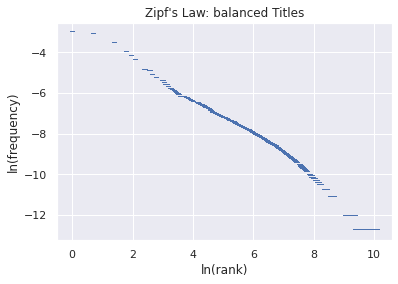

In [ ]:
zipf_balanced_title_data = np.array(balanced_title_normalized_vocab_df['count'])
zipf_balanced_title_data = np.log(zipf_balanced_title_data / zipf_balanced_title_data.sum())
zipf_balanced_title_plot = sns.scatterplot(y=zipf_balanced_title_data,
                            x=np.log(np.arange(1, len(zipf_balanced_title_data) + 1)), 
                            marker='$-$',
                            edgecolor='none')
zipf_balanced_title_plot.set_title("Zipf's Law: balanced Titles")
zipf_balanced_title_plot.set_xlabel('ln(rank)')
zipf_balanced_title_plot.set_ylabel('ln(frequency)')
zipf_balanced_title_plot.get_figure().savefig(FOLDERNAME + 'figures/zipf_balanced_title_plot.svg')

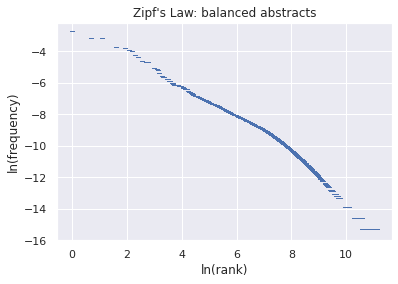

In [ ]:
zipf_balanced_abstract_data = np.array(balanced_abstract_normalized_vocab_df['count'])
zipf_balanced_abstract_data = np.log(zipf_balanced_abstract_data / zipf_balanced_abstract_data.sum())
zipf_balanced_abstract_plot = sns.scatterplot(y=zipf_balanced_abstract_data,
                            x=np.log(np.arange(1, len(zipf_balanced_abstract_data) + 1)), 
                            marker='$-$',
                            edgecolor='none')
zipf_balanced_abstract_plot.set_title("Zipf's Law: balanced abstracts")
zipf_balanced_abstract_plot.set_xlabel('ln(rank)')
zipf_balanced_abstract_plot.set_ylabel('ln(frequency)')
zipf_balanced_abstract_plot.get_figure().savefig(FOLDERNAME + 'figures/zipf_balanced_abstract_plot.svg')

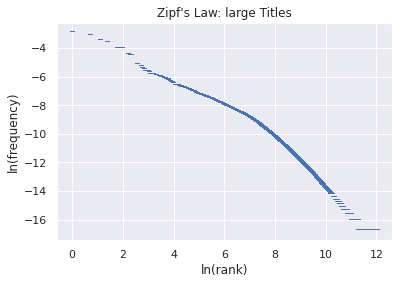

In [ ]:
zipf_large_title_data = np.array(large_title_normalized_vocab_df['count'])
zipf_large_title_data = np.log(zipf_large_title_data / zipf_large_title_data.sum())
zipf_large_title_plot = sns.scatterplot(y=zipf_large_title_data,
                            x=np.log(np.arange(1, len(zipf_large_title_data) + 1)), 
                            marker='$-$',
                            edgecolor='none')
zipf_large_title_plot.set_title("Zipf's Law: large Titles")
zipf_large_title_plot.set_xlabel('ln(rank)')
zipf_large_title_plot.set_ylabel('ln(frequency)')
zipf_large_title_plot.get_figure().savefig(FOLDERNAME + 'figures/zipf_large_title_plot.svg')

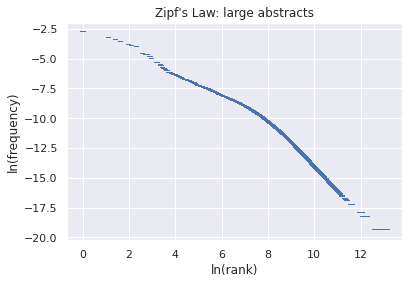

In [ ]:
zipf_large_abstract_data = np.array(large_abstract_normalized_vocab_df['count'])
zipf_large_abstract_data = np.log(zipf_large_abstract_data / zipf_large_abstract_data.sum())
zipf_large_abstract_plot = sns.scatterplot(y=zipf_large_abstract_data,
                            x=np.log(np.arange(1, len(zipf_large_abstract_data) + 1)), 
                            marker='$-$',
                            edgecolor='none')
zipf_large_abstract_plot.set_title("Zipf's Law: large abstracts")
zipf_large_abstract_plot.set_xlabel('ln(rank)')
zipf_large_abstract_plot.set_ylabel('ln(frequency)')
zipf_large_abstract_plot.get_figure().savefig(FOLDERNAME + 'figures/zipf_large_abstract_plot.svg')